<h1>Semester Project for Decision Systems 2020/2021 (University of Warsaw)<h1>
    <h2>Joanna Kęczkowska<h2>

The goal of the competition is to create an efficient model for predicting whether the total 14-days sales of a particular product, offered by the Fitfood company at one of their FitBoxy locations in Poland, will exceed four pieces.

Provided data describe a short-term sales history of products at various point of sales (PoS). The target attribute will_it_sell tells if in the following 14 day period the total sales of a given product at a particular location will be at least 4 pcs. 

The data tables are provided as two CSV files with the ';' separator sign.

<h3>Data preparation<h3>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
import lightgbm as lgbm
import numpy as np
from sklearn.model_selection import cross_val_score

In [2]:
dataSet = pd.read_csv("FitFood_competition_data_training.csv", sep=';')
dataSet.shape

(531824, 97)

In [3]:
dataSet.describe()

,will_it_sell,product_id_unified,partner_product,cooking_mv,cooking_ov,vat,bialko_100,weglow_100,cukry_calk,tluszcz_nasyc_calk,...,avg_total_to_discount_lag1,avg_total_base_lag1,avg_sum_fv_lag1,avg_transaction_discount_count_lag1,roc1_lag1,rocPeriod_lag1,days_since_prev_delivery,sales_since_prev_delivery,available_products,is_delivery_day
count,531824.000000,531824.000000,531824.000000,231884.0,231884.0,531824.000000,496291.00000,496290.000000,496202.000000,496202.000000,...,5.288900e+05,528890.000000,528890.0,528890.000000,528890.000000,528890.000000,474094.000000,474094.000000,476634.000000,531823.000000
mean,0.119477,1104.984531,0.091600,1.0,1.0,6.628563,7.47106,19.206512,8.332242,3.861230,...,7.927875e-01,3.106582,0.0,0.098661,-0.001819,-0.008464,16.806237,0.351909,1.197972,0.118019
std,0.324350,55.861218,0.288461,0.0,0.0,4.417655,6.73606,15.012734,7.248779,3.268845,...,3.095363e+00,6.165410,0.0,0.292494,0.237530,0.622241,30.601578,1.024078,3.569655,0.322630
min,0.000000,1004.000000,0.000000,1.0,1.0,5.000000,0.00000,2.700000,0.200000,0.000000,...,-1.421085e-13,0.000000,0.0,0.000000,-2.772589,-3.465736,1.000000,0.000000,-24.000000,0.000000
25%,0.000000,1057.000000,0.000000,1.0,1.0,5.000000,3.20000,9.200000,3.000000,1.500000,...,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,1117.000000,0.000000,1.0,1.0,5.000000,6.80000,13.000000,5.900000,3.000000,...,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
75%,0.000000,1152.000000,0.000000,1.0,1.0,5.000000,8.90000,23.400000,12.600000,5.100000,...,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,9.000000,0.000000,2.000000,0.000000
max,1.000000,1193.000000,1.000000,1.0,1.0,23.000000,38.00000,61.300000,29.500000,14.300000,...,6.965000e+01,187.840000,0.0,3.000000,2.772589,3.465736,256.000000,31.000000,601.000000,1.000000


In [4]:
dataSet.head()

,will_it_sell,pos_id,product_id_unified,company_id,category_id,category_name,product_name,partner_product,address_city,diet,...,avg_total_to_discount_lag1,avg_total_base_lag1,avg_sum_fv_lag1,avg_transaction_discount_count_lag1,roc1_lag1,rocPeriod_lag1,days_since_prev_delivery,sales_since_prev_delivery,available_products,is_delivery_day
0,1,5cd2c7b75314a576b410fb6f,1146,5cc01f99def57b4350f57e6f,59005cd6c5c79d3575eb450d,Przekąski,"Superfood SPORT - banan, białko",1,Wrocław,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0
1,0,5b291c490663ab48e334abce,1136,5b9fa5e201f82e03b412bcff,5a0033206cdc0d08a6591bfb,Dania Lunch Małe,Szaszłyk z ryżem w kurkumie,0,Kraków,Dieta Samuraja,...,13.99,13.99,0.0,1.0,0.0,1.609438,NaN,NaN,NaN,0.0
2,0,5b1bb68ecaef965005d0e938,1051,5b1f8a17caef965005d12d7e,5abe0aed049e180557e22330,Sałatki,FitSalad - Sałatka z kurczakiem i grillowanymi...,0,Warszawa,--,...,0.00,0.00,0.0,0.0,0.0,0.000000,71.0,0.0,0.0,0.0
3,0,5cdbd1ba9083f77a4476ff58,1069,5d14ae03ad08444d3ee1eecd,5cd1a4d32b10792bc08dab31,Pan Pomidor - Pierogi,Pierogi ruskie,0,Wrocław,NaN,...,0.00,0.00,0.0,0.0,0.0,0.000000,2.0,0.0,0.0,0.0
4,0,5c1232411462a123065f3b58,1135,5beada3478729f2c8afeeb90,5a0033206cdc0d08a6591bfb,Dania Lunch Małe,Pikantny ryż jaśminowy smażony z jajkiem,0,Katowice,Dieta Samuraja,...,0.00,0.00,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,0.0


In [5]:
import numpy as np

#Getting categorical data
df_cat = dataSet.loc[:,dataSet.dtypes==np.object]
#Getting Numeric data
df_num = dataSet.loc[:,dataSet.dtypes!=np.object]

dataSet.info()

y = dataSet.pop('will_it_sell')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531824 entries, 0 to 531823
Data columns (total 97 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   will_it_sell                         531824 non-null  int64  
 1   pos_id                               531824 non-null  object 
 2   product_id_unified                   531824 non-null  int64  
 3   company_id                           531824 non-null  object 
 4   category_id                          531824 non-null  object 
 5   category_name                        531824 non-null  object 
 6   product_name                         531824 non-null  object 
 7   partner_product                      531824 non-null  int64  
 8   address_city                         531824 non-null  object 
 9   diet                                 282103 non-null  object 
 10  size                                 531824 non-null  object 
 11  cooking_time 

In [6]:
y.value_counts()

0    468283
1     63541
Name: will_it_sell, dtype: int64

**Note:** Features must be numeric with meaningful magnitude. We will cover this later.\
Now we need to split -dataSet- to training set and testing set.  If we want to (approximately) keep the proportion of y values through the training and test sets, then we need to pass stratify=y. This will enable stratified splitting:

In [7]:

#X_train - dataset for training and tuning hyperparameters, X_test - dataset for evaluating our model
X_train, X_test, y_train, y_test = train_test_split(dataSet, y, test_size=0.2, random_state=42, stratify=y) 
#data was split in a stratified fashion

In [8]:
objlist = X_train.select_dtypes(include="object").columns
for cols in objlist:
    print('___________')
    print(X_train[cols].value_counts())

___________
596e2a5371059a6bc70a818b    2053
5b1b963bcaef965005d0e6b0    2027
5b61699404852c4704a26f28    2016
59fc5325c94b722506678bd1    2011
5b1bad72caef965005d0e891    2007
                            ... 
5dc69e723bf8f15dc97ec4de       5
5dc694443bf8f15dc97ec3c7       5
5dcd4c06dacdf109c179d79b       3
5dcbccb4aa5f032f78d77579       2
5dcd2fb58fc7d108e6b8bc09       1
Name: pos_id, Length: 375, dtype: int64
___________
5a587706cf5c8134b3a9891d    7952
5c48270855f3af637b69b13f    7559
5b9fa5e201f82e03b412bcff    6331
5b503c4a9586df16bbb6e07a    6135
5c924f69b6cb840dcac430fe    5983
                            ... 
5dbff3dd9f38f239c2ffeb0c      20
5dc534a2fdcd0622bd7b34e5      18
5e4550dd177446520bcd2c91      11
5d764e2fd0c59c62f781ff36       5
5d764e24bf7a586310594da4       4
Name: company_id, Length: 298, dtype: int64
___________
5a6f110ca0899f5ca2f7d6e9    90519
59005cd6c5c79d3575eb450d    73645
5a0033206cdc0d08a6591bfb    63665
591301c83dd75608a9c2ef1b    39234
590053bdc5c79d3575

File "encoding" contains pipelines with list of transforms for categorial variables and numeric variables.   
##### For categorial variables:  
**Simple imputer** fills missing cells with 'missing'.  
**HashEncoder** is suitable for categorial variables with large numer of levels.  
**OneHotEncoder** refers to splitting the column which contains numerical categorical data to many columns depending on the number of categories present in that column. Each column contains “0” or “1” corresponding to which column it has been placed.   Collinear features cause problems, such as when feeding the resulting data into a neural network or an unregularized regression. Therefore parameter drop='first'.

##### For numeric variables:  
**Simple imputer** fills missing cells with mode for each column.  

In [9]:
from encoding import encode

#colmun of the same value in each row is useless
del X_train["cooking_time"]
del X_test["cooking_time"]

X_train, X_test=encode(X_train, X_test)

In [10]:
X_train.to_csv("X_train.csv", sep=';', encoding='utf-8')
y_train.to_csv("y_train.csv", sep=';', encoding='utf-8')
X_test.to_csv("X_test.csv", sep=';', encoding='utf-8')
y_test.to_csv("y_test.csv", sep=';', encoding='utf-8')

**LightGBM** is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage. It uses two novel techniques: Gradient-based One Side Sampling and Exclusive Feature Bundling (EFB) which fulfills the limitations of histogram-based algorithm that is primarily used in all GBDT (Gradient Boosting Decision Tree) frameworks. The two techniques of GOSS and EFB described below form the characteristics of LightGBM Algorithm. They comprise together to make the model work efficiently and provide it a cutting edge over other GBDT frameworks

**Architecture**  
LightGBM splits the tree leaf-wise as opposed to other boosting algorithms that grow tree level-wise. It chooses the leaf with maximum delta loss to grow. Since the leaf is fixed, the leaf-wise algorithm has lower loss compared to the level-wise algorithm. Leaf-wise tree growth might increase the complexity of the model and may lead to overfitting in small datasets.

In [12]:
model = lgbm.LGBMClassifier(device="gpu")
model.fit(X_train, y_train)
preds = model.predict(X_test)
filename = 'finalized_model.sav'
model.booster_.save_model(filename)


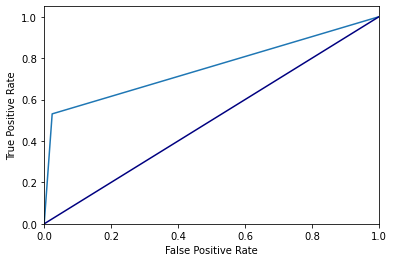

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
metrics.auc(fpr, tpr)


roc_auc = dict()
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


#not great not terrible

In [14]:
metrics.confusion_matrix(y_test, preds)

array([[91427,  2230],
       [ 5962,  6746]], dtype=int64)

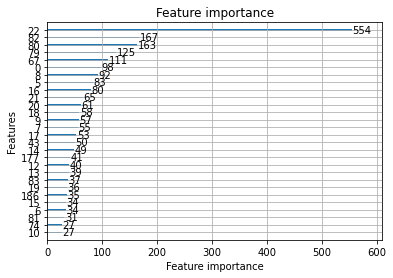

In [15]:
ax = lgbm.plot_importance(model, max_num_features=28)
ax.figure.savefig('feature_importance_lgbm.png')

In [16]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'gpu'}

### **Parameter Tuning**  
Few important parameters and their usage is listed below :  

**max_depth** : It sets a limit on the depth of tree. The default value is 20. It is effective in controlling over fitting.  
**categorical_feature** : It specifies the categorical feature used for training model.   
**bagging_fraction** : It specifies the fraction of data to be considered for each iteration.  
**num_iterations** : It specifies the number of iterations to be performed. The default value is 100.  
**num_leaves** : It specifies the number of leaves in a tree. It should be smaller than the square of max_depth.  
**max_bin** : It specifies the maximum number of bins to bucket the feature values.  
**min_data_in_bin** : It specifies minimum amount of data in one bin.  
**task** : It specifies the task we wish to perform which is either train or prediction. The default entry is train. Another possible value for this parameter is prediction.  
**feature_fraction** : It specifies the fraction of features to be considered in each iteration. The default value is one.  


In [17]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

In [2]:
FIXED_PARAMS={'objective': 'binary', 
              'metric': ["auc","error", "Binary_logloss"],
              'is_unbalance':True
             }

In [19]:
model = lgbm.LGBMClassifier(device="gpu")
model.set_params(**FIXED_PARAMS)
model.fit(X_train, y_train)
preds = model.predict(X_validate)

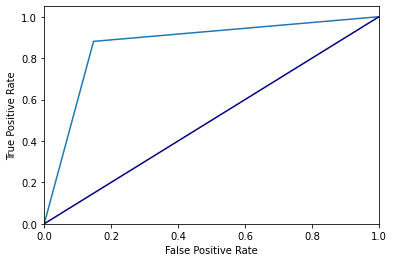

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_validate, preds)
metrics.auc(fpr, tpr)


roc_auc = dict()
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#getting better

In [21]:
metrics.confusion_matrix(y_validate, preds)

array([[63880, 11045],
       [ 1211,  8956]], dtype=int64)

In [22]:
metrics.auc(fpr, tpr)

0.8667375352139786

In [23]:
n_HP_points_to_test = 100 #This parameter defines the number of HP points to be tested
param_test ={'num_leaves': sp_randint(6, 80), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }

gs = RandomizedSearchCV(
    estimator=model, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='neg_log_loss',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [24]:
gs.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 37.4min finished


Best score reached: -0.30132820860488735 with params: {'colsample_bytree': 0.9644122653638829, 'min_child_samples': 281, 'min_child_weight': 0.001, 'num_leaves': 79, 'reg_alpha': 2, 'reg_lambda': 50, 'subsample': 0.3124968711594125} 


### Final learning 

In [25]:
final_lgbm_model = lgbm.LGBMClassifier(**FIXED_PARAMS, device="gpu")
#params = {'colsample_bytree': 0.9348023686516402, 'min_child_samples': 351, 'min_child_weight': 10.0, 'num_leaves': 47, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.49447771753795894}
final_lgbm_model.set_params(**gs.best_params_)
data =  pd.read_csv("X_train.csv", sep=';', encoding='utf-8')
data = data.iloc[:, 1:]
label = pd.read_csv("y_train.csv", sep=';', encoding='utf-8')
y = pd.DataFrame(label["will_it_sell"])

final_lgbm_model.fit(data, y)

C:\Users\Asia\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier(colsample_bytree=0.9644122653638829, device='gpu',
               is_unbalance=True, metric=['auc', 'error', 'Binary_logloss'],
               min_child_samples=281, num_leaves=79, objective='binary',
               reg_alpha=2, reg_lambda=50, subsample=0.3124968711594125)

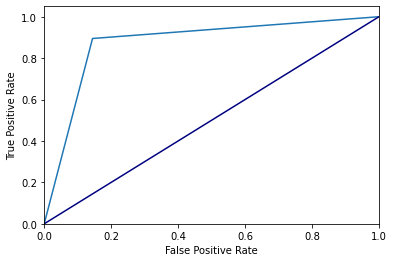

In [26]:
preds = final_lgbm_model.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
metrics.auc(fpr, tpr)


roc_auc = dict()
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [27]:
metrics.confusion_matrix(y_test, preds)

array([[80135, 13522],
       [ 1336, 11372]], dtype=int64)

In [28]:
metrics.auc(fpr, tpr)

0.8752457420449156

In [29]:
preds_prob = final_lgbm_model.predict_proba(X_test)
metrics.brier_score_loss(y_test, preds_prob[:,1])

0.09628477405027651

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_prob[:, 1])
metrics.auc(fpr, tpr)

0.9471313658772207

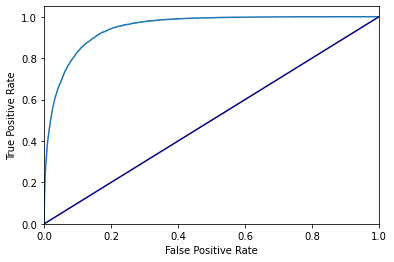

In [31]:
roc_auc = dict()
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Previous models didn't have lgbm classifier in pipline. Classification with imputed values may be missleading when we want to validate our classifier with for example k-fold CV. So: 

### Combining transformers and estimators in a pipeline

File pipeline.py generates pipline from imputers and provided model (in this case LGBMClassifier).

In [3]:
dataSet = pd.read_csv("FitFood_competition_data_training.csv", sep=';')
y = dataSet.pop('will_it_sell')
X_train, X_test, y_train, y_test = train_test_split(dataSet, y, test_size=0.2, random_state=42, stratify=y) 
del X_train["cooking_time"]
del X_test["cooking_time"]
dataSet.shape


(531824, 96)

In [4]:
from pipeline import model

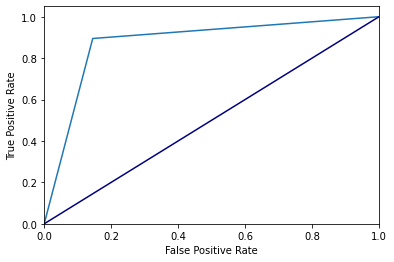

In [5]:
paramed_model = lgbm.LGBMClassifier(**FIXED_PARAMS, device="gpu")
bst = {'colsample_bytree': 0.9644122653638829, 'min_child_samples': 281, \
       'min_child_weight': 0.001, 'num_leaves': 79, 'reg_alpha': 2, 'reg_lambda': 50, \
       'subsample': 0.3124968711594125} 
paramed_model.set_params(**bst)
X_train, X_validate, y_train, y_validate = train_test_split(dataSet, y, test_size=0.2, random_state=42, stratify=y) 

pip_est = model(paramed_model, X_train)
pip_est.fit(X_train, y_train)

preds = pip_est.predict(X_validate)

fpr, tpr, thresholds = metrics.roc_curve(y_validate, preds)


roc_auc = dict()
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [6]:
metrics.auc(fpr, tpr)

0.8749574560652238

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn import set_config


set_config(display='diagram')
pip_est


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer3',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['product_id_unified', 'partner_product', 'cooking_mv', 'cooking_ov',
       'vat', 'bialko_100', 'weglow_100', 'cukry_calk', 'tluszcz_nasyc_calk',
       'energia_calk', 'energia_100', 'tluszcz_nasyc_100', 'blonnik_100',
       'tluszc...
                                                                  ('encoder2',
                                                                   HashingEncoder(max_process=2))]),
                                                  ['pos_id', 'company_id',
                                                   'product_name',
                                                   'cooking_time'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.9644122653638829,
                                device='gpu', is_unbalance=True,
                                metric=['auc', 'error', 'Binary_logloss'],
                                min_child_samples=281, num_leaves=79,
                                objective='binary', reg_alpha=2, reg_lambda=50,
                                subsample=0.3124968711594125))])

### Bias–variance tradeoff

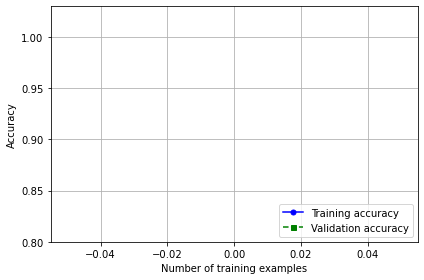

In [15]:
# train_sizes, train_scores, test_scores =\
#                 learning_curve(estimator=pip_est,
#                                X=X_train,
#                                y=y_train,
#                                train_sizes=np.linspace(0.1, 1.0, 10),
#                                cv=10,
#                                n_jobs=3)

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.plot(train_sizes, train_mean,
#          color='blue', marker='o',
#          markersize=5, label='Training accuracy')

# plt.fill_between(train_sizes,
#                  train_mean + train_std,
#                  train_mean - train_std,
#                  alpha=0.15, color='blue')

# plt.plot(train_sizes, test_mean,
#          color='green', linestyle='--',
#          marker='s', markersize=5,
#          label='Validation accuracy')

# plt.fill_between(train_sizes,
#                  test_mean + test_std,
#                  test_mean - test_std,
#                  alpha=0.15, color='green')
# plt.grid()
# plt.xlabel('Number of training examples')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.ylim([0.8, 1.03])
# plt.tight_layout()
# plt.show()

**Bibliography**:
> https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/  
> https://neptune.ai/blog/lightgbm-parameters-guide  
> https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html  
> https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb (ig. Raschka Mirjalili Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition )